# 12. Ajuste avanzado modelo Bagging, clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
from numpy import arange


Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

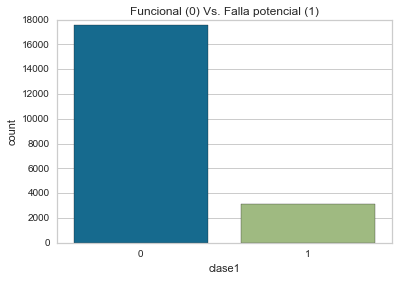

In [5]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [6]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [7]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

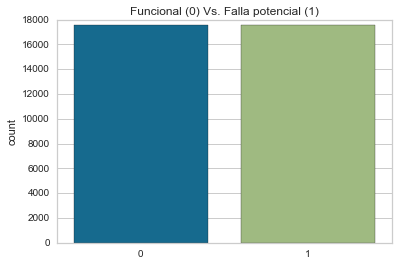

In [8]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [9]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [10]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 25)
total datos = 876550


In [11]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [12]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo

## Bagging Ensemble Classifier hiperparametros por defecto

In [13]:
modelo1=BaggingClassifier(random_state=0)
modelo1.fit(data_train, label_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)



MATRIZ DE CONFUSION




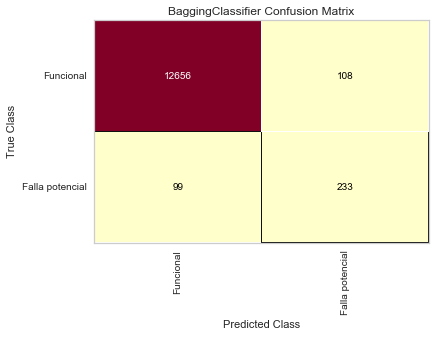



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9841936469150886
ROC AUC: 0.846672965758364
------------------------------------------------------------
Precisión por clase: [0.99223834 0.68328446]
Sensibilidad - Recall por clase: [0.9915387  0.70180723]
F1 por clase: [0.9918884  0.69242199]
------------------------------------------------------------
F1 Macro: 0.8421551939827254
F1 Micro: 0.9841936469150886
F1 Weighted: 0.9842965484748079
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.846672965758364
Sensibilidad - Recall Micro: 0.9841936469150886
Sensibilidad - Recall Weighted: 0.9841936469150886
------------------------------------------------------------
Precisión Macro: 0.8377613976923546
Precisión Micro: 0.9841936469150886
Precisión Weighted: 0.9844059701377411
------------------------------------------------------------
Verdaderos positivos - True Positives: 233
Verdaderos negativos - True Negatives: 12656
Falsos positivos

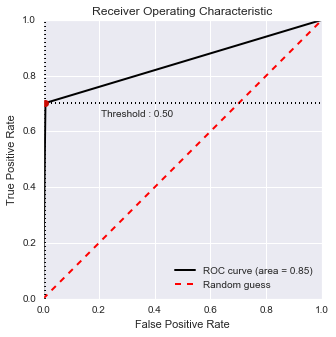

In [14]:
label_pred1 = modelo1.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

## Stratified k-fold cross-validation

Evaluaremos el modelo utilizando validación cruzada estratificada repetida de k veces, con 10 repeticiones y 10 pliegues. Informaremos la desviación media y estándar de la precisión del modelo en todas las repeticiones y pliegues

In [14]:
# evaluar 

model = BaggingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.972 (0.003)


El resultado es una exactitud media de 0.972 con una desviacion estandar de 0.003

## Ajuste de hiperparametros
tomado de https://machinelearningmastery.com/bagging-ensemble-with-python/

### Explorar el numero de arboles 

In [16]:
# funcion para evaluar lista de modelos
def get_models():
    models = dict()
    models['10'] = BaggingClassifier(n_estimators=10)
    models['50'] = BaggingClassifier(n_estimators=50)
    models['100'] = BaggingClassifier(n_estimators=100)
    models['500'] = BaggingClassifier(n_estimators=500)
    models['1000'] = BaggingClassifier(n_estimators=1000)
    models['5000'] = BaggingClassifier(n_estimators=5000)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>10 0.972 (0.003)
>50 0.975 (0.003)
>100 0.976 (0.003)
>500 0.976 (0.002)
>1000 0.975 (0.002)
>5000 0.976 (0.002)


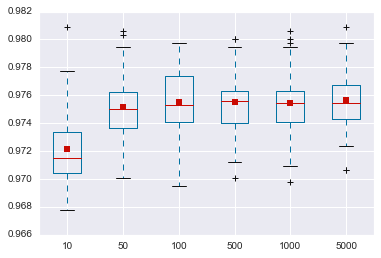

In [17]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

se observa que la exactitud aumenta y se mantiene estable después de unos 100 árboles


### Ajustar el Number of Samples (max_samples)

In [20]:
def get_models():
    models = dict()
    for i in arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = BaggingClassifier(n_estimators=100, max_samples=i)
    return models
 
# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 


>0.1 0.961 (0.003)
>0.2 0.966 (0.003)
>0.3 0.969 (0.003)
>0.4 0.971 (0.003)
>0.5 0.972 (0.003)
>0.6 0.973 (0.003)
>0.7 0.974 (0.002)
>0.8 0.975 (0.002)
>0.9 0.975 (0.003)
>1.0 0.975 (0.002)


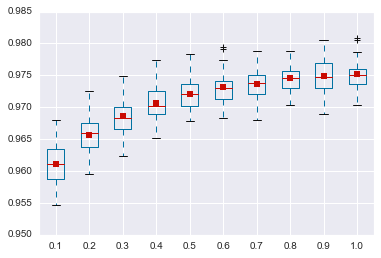

In [21]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# grafico de cajas y bigotes 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

los resultados sugieren que se selecciones el numero de muestras =1

## Entrenar modelo con hiperparametros ajustados 

In [27]:
modelo2=BaggingClassifier(n_estimators=100, max_samples=1.0, random_state=0)
modelo2.fit(data_train, label_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=100,
                  n_jobs=None, oob_score=False, random_state=0, verbose=0,
                  warm_start=False)



MATRIZ DE CONFUSION




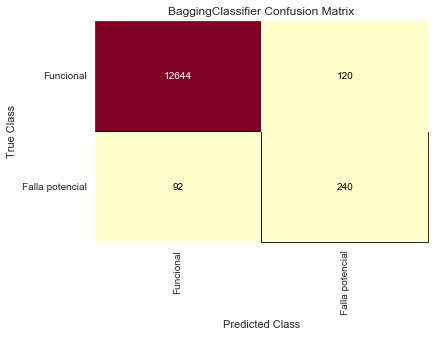



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.983811850946854
ROC AUC: 0.8567450623553442
------------------------------------------------------------
Precisión por clase: [0.99277638 0.66666667]
Sensibilidad - Recall por clase: [0.99059856 0.72289157]
F1 por clase: [0.99168627 0.69364162]
------------------------------------------------------------
F1 Macro: 0.8426639465034569
F1 Micro: 0.983811850946854
F1 Weighted: 0.9841304692413086
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8567450623553443
Sensibilidad - Recall Micro: 0.983811850946854
Sensibilidad - Recall Weighted: 0.983811850946854
------------------------------------------------------------
Precisión Macro: 0.8297215242881072
Precisión Micro: 0.983811850946854
Precisión Weighted: 0.9845090922439524
------------------------------------------------------------
Verdaderos positivos - True Positives: 240
Verdaderos negativos - True Negatives: 12644
Falsos positivos - 

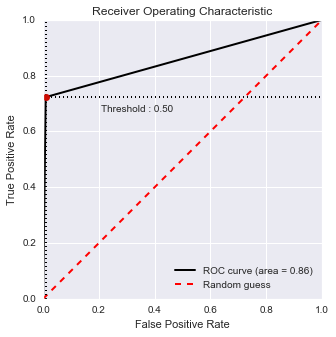

In [28]:
label_pred2 = modelo2.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2, label_pred2)

Se obtiene una mejora leve en numero de falsos negativos y falsos positivos

## Bagging with KNN
Algoritmo alternativo

>1 0.973 (0.002)
>2 0.969 (0.003)
>3 0.966 (0.003)
>4 0.964 (0.003)
>5 0.961 (0.003)
>6 0.960 (0.003)
>7 0.958 (0.003)
>8 0.958 (0.003)
>9 0.956 (0.003)
>10 0.956 (0.003)
>11 0.955 (0.003)
>12 0.954 (0.003)
>13 0.954 (0.003)
>14 0.953 (0.003)
>15 0.953 (0.003)
>16 0.953 (0.003)
>17 0.952 (0.003)
>18 0.951 (0.004)
>19 0.951 (0.003)
>20 0.951 (0.003)


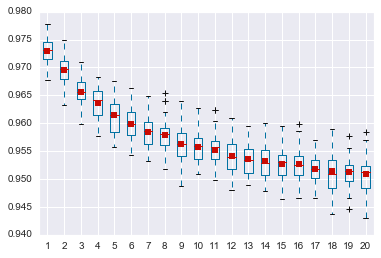

In [29]:
# lista de modelos a evaluar
def get_models():
    models = dict()
    for i in range(1,21):
        models[str(i)] = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=i))
    return models
 
# evaluar modelos usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Entrenar Bagging with KNN modelo con hiperparametros ajustados 

In [32]:
modelo3=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1), random_state=0, n_estimators=100 )
modelo3.fit(data_train, label_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                      leaf_size=30,
                                                      metric='minkowski',
                                                      metric_params=None,
                                                      n_jobs=None,
                                                      n_neighbors=1, p=2,
                                                      weights='uniform'),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=100, n_jobs=None,
                  oob_score=False, random_state=0, verbose=0, warm_start=False)



MATRIZ DE CONFUSION




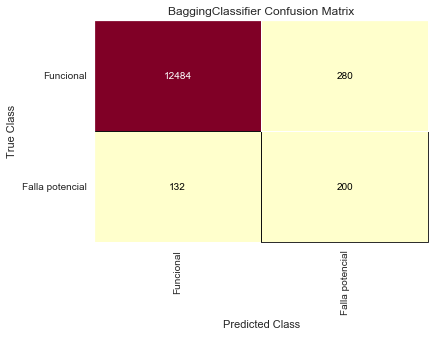



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.968540012217471
ROC AUC: 0.7902364707970081
------------------------------------------------------------
Precisión por clase: [0.9895371  0.41666667]
Sensibilidad - Recall por clase: [0.9780633  0.60240964]
F1 por clase: [0.98376675 0.49261084]
------------------------------------------------------------
F1 Macro: 0.7381887914536484
F1 Micro: 0.968540012217471
F1 Weighted: 0.9713153281302881
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7902364707970082
Sensibilidad - Recall Micro: 0.968540012217471
Sensibilidad - Recall Weighted: 0.968540012217471
------------------------------------------------------------
Precisión Macro: 0.7031018812090467
Precisión Micro: 0.968540012217471
Precisión Weighted: 0.9750141129737742
------------------------------------------------------------
Verdaderos positivos - True Positives: 200
Verdaderos negativos - True Negatives: 12484
Falsos positivos - 

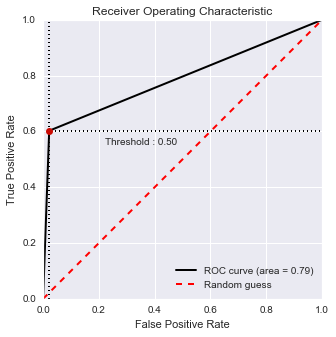

In [33]:
label_pred3 = modelo3.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo3, label_pred3)

No se obtienene buen resulytado al reemplazar los arboles de decision con KNN